In [1]:
#Author: Shubham Shantaram Pawar

In [2]:
# For this project, only essay set 1 was used for analysis and model creation.

# Features:
# 1. Bag of Words (BOW) counts (10000 words with maximum frequency)
# 2. Number of characters in an essay
# 3. Number of words in an essay
# 4. Number of sentences in an essay
# 5. Average word length of an essay
# 6. Number of lemmas in an essay
# 7. Number of spellng errors in an essay
# 8. Number of nouns in an essay
# 9. Number of adjectives in an essay
# 10. Number of verbs in an essay
# 11. Number of adverbs in an essay

# Models:

# 1. Using only BOW features:
#     a. Linear Regression
#     b. Lasso Regression
# 2. Using only numerical/POS/Orthographic features:
#     a. Linear Regression
#     b. Ridge Regression
#     c. Lasso Regression
#     d. Gradient Boosting Regression
# 3. Using all features:
#     a. Linear Regression
#     b. Ridge Regression
#     c. Lasso Regression
#     d. Support Vector Regression
#     e. Gradient Boosting Regression

# Model Evaluation:

# 1. Parameter Tuning: Using GridSearchCV
# 2. Error: mean_squared_error - a risk metric corresponding to the expected value of the squared (quadratic) error or loss
# 3. Variance: estimator score() function or r2_score - R², the coefficient of determination; provides a measure of 
#    how well future samples are likely to be predicted by the model
# 4. Score Agreement: cohen_kappa_score - measures inter-rater agreement; takes into account the possibility of the agreement 
#    occurring by chance

In [19]:
# importing required packages

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from scipy import optimize as op
from sklearn.metrics import accuracy_score 

In [4]:
# getting data in a pandas dataframe

dataframe = pd.read_csv('essays_and_scores.csv', encoding = 'latin-1')

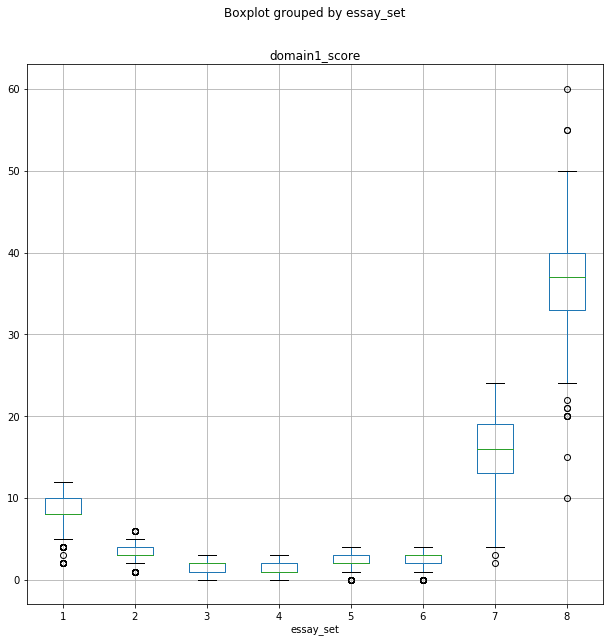

In [5]:
# Boxlot can be used to visualize the distribution of domain1_score values over each essay set.

%matplotlib inline
dataframe.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))

In [6]:
# getting relevant columns

data = dataframe[['essay_set','essay','domain1_score']].copy()

print(data)

       essay_set                                              essay  \
0              1  Dear local newspaper, I think effects computer...   
1              1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2              1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3              1  Dear Local Newspaper, @CAPS1 I have found that...   
4              1  Dear @LOCATION1, I know having computers has a...   
5              1  Dear @LOCATION1, I think that computers have a...   
6              1  Did you know that more and more people these d...   
7              1  @PERCENT1 of people agree that computers make ...   
8              1  Dear reader, @ORGANIZATION1 has had a dramatic...   
9              1  In the @LOCATION1 we have the technology of a ...   
10             1  Dear @LOCATION1, @CAPS1 people acknowledge the...   
11             1  Dear @CAPS1 @CAPS2 I feel that computers do ta...   
12             1  Dear local newspaper I raed ur argument on the...   
13    

In [7]:
# Tokenize a sentence into words

def sentence_to_wordlist(raw_sentence):
    
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    
    return tokens

In [8]:
# tokenizing an essay into a list of word lists

def tokenize(essay):
    stripped_essay = essay.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    
    return tokenized_sentences

In [9]:
# calculating average word length in an essay

def avg_word_len(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return sum(len(word) for word in words) / len(words)

In [10]:
# calculating number of words in an essay

def word_count(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return len(words)

In [11]:
# calculating number of characters in an essay

def char_count(essay):
    
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    
    return len(clean_essay)

In [12]:
# calculating number of sentences in an essay

def sent_count(essay):
    
    sentences = nltk.sent_tokenize(essay)
    
    return len(sentences)

In [13]:
# calculating number of lemmas per essay

def count_lemmas(essay):
    
    tokenized_sentences = tokenize(essay)      
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return lemma_count

In [14]:
# checking number of misspelled words

def count_spell_error(essay):
    
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
    
    #big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg 
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()
    
    words_ = re.findall('[a-z]+', data.lower())
    
    word_dict = collections.defaultdict(lambda: 0)
                       
    for word in words_:
        word_dict[word] += 1
                       
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
                        
    mispell_count = 0
    
    words = clean_essay.split()
                        
    for word in words:
        if not word in word_dict:
            mispell_count += 1
    
    return mispell_count

In [15]:
# calculating number of nouns, adjectives, verbs and adverbs in an essay

def count_pos(essay):
    
    tokenized_sentences = tokenize(essay)
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            
    return noun_count, adj_count, verb_count, adv_count
    

In [16]:
# getiing Bag of Words (BOW) counts

def get_count_vectors(essays):
    
    vectorizer = CountVectorizer(max_features = 10000, ngram_range=(1, 3), stop_words='english')
    
    count_vectors = vectorizer.fit_transform(essays)
    
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, count_vectors

In [17]:
# splitting data into train data and test data (70/30)

feature_names_cv, count_vectors = get_count_vectors(data[data['essay_set'] == 1]['essay'])

X_cv = count_vectors.toarray()

y_cv = data[data['essay_set'] == 1]['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [24]:
# Training a Linear Regression model using only Bag of Words (BOW)

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))



Coefficients: 
 [-7.20137236e-03  1.63571652e-01  4.53623851e-03 ... -3.02042904e-05
  2.91752747e-02 -1.75943687e-02]
Mean squared error: 1.61
Variance score: 0.34
Cohen's kappa score: 0.19


In [19]:
# Training a Lasso Regression model (l1 regularization) using only Bag of Words (BOW)

alphas = np.array([3, 1, 0.3, 0.1, 0.03, 0.01])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.507225317737818
0.03
Mean squared error: 1.20
Variance score: 0.53
Cohen's kappa score: 0.22


In [20]:
# extracting essay features

def extract_features(data):
    
    features = data.copy()
    
    features['char_count'] = features['essay'].apply(char_count)
    
    features['word_count'] = features['essay'].apply(word_count)
    
    features['sent_count'] = features['essay'].apply(sent_count)
    
    features['avg_word_len'] = features['essay'].apply(avg_word_len)
    
    features['lemma_count'] = features['essay'].apply(count_lemmas)
    
    features['spell_err_count'] = features['essay'].apply(count_spell_error)
    
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(*features['essay'].map(count_pos))
    
    return features

In [21]:
# extracting features from essay set 1

features_set1 = extract_features(data[data['essay_set'] == 1])

print(features_set1)

      essay_set                                              essay  \
0             1  Dear local newspaper, I think effects computer...   
1             1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2             1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3             1  Dear Local Newspaper, @CAPS1 I have found that...   
4             1  Dear @LOCATION1, I know having computers has a...   
5             1  Dear @LOCATION1, I think that computers have a...   
6             1  Did you know that more and more people these d...   
7             1  @PERCENT1 of people agree that computers make ...   
8             1  Dear reader, @ORGANIZATION1 has had a dramatic...   
9             1  In the @LOCATION1 we have the technology of a ...   
10            1  Dear @LOCATION1, @CAPS1 people acknowledge the...   
11            1  Dear @CAPS1 @CAPS2 I feel that computers do ta...   
12            1  Dear local newspaper I raed ur argument on the...   
13            1  My 

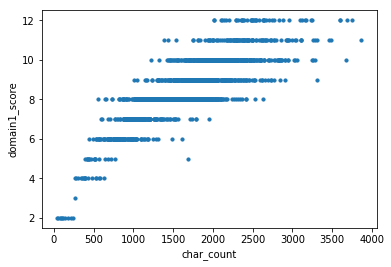

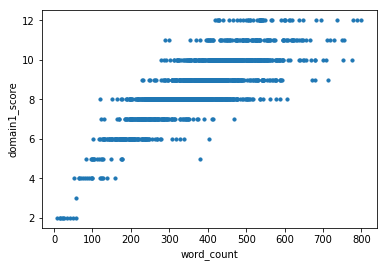

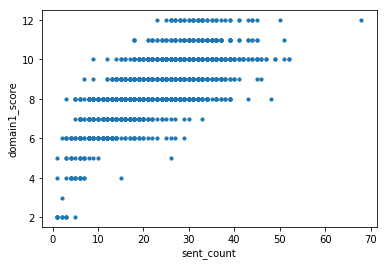

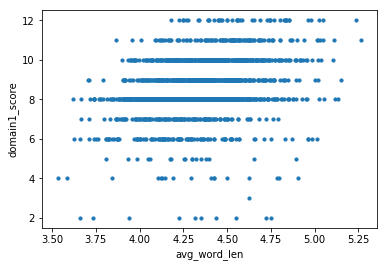

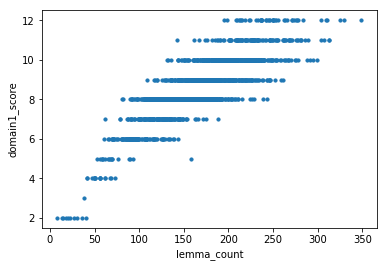

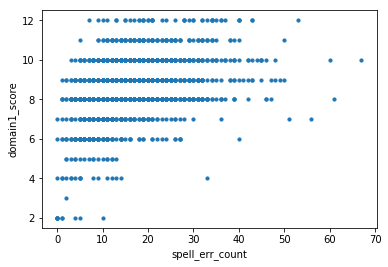

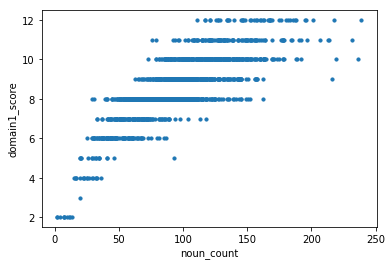

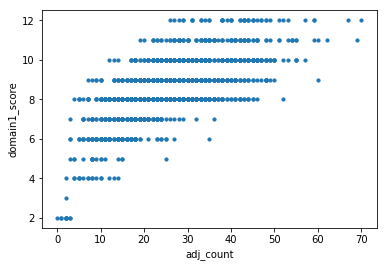

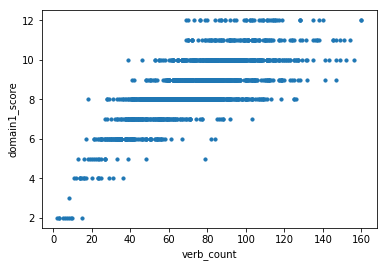

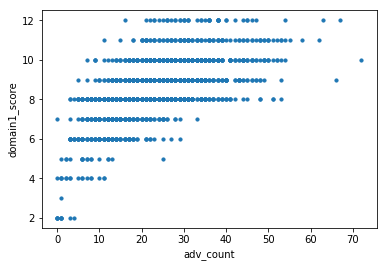

In [22]:
# Exploratory Data Analysis (EDA) on the data

%matplotlib inline
features_set1.plot.scatter(x = 'char_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'word_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'sent_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'avg_word_len', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'lemma_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'spell_err_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'noun_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adj_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'verb_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adv_count', y = 'domain1_score', s=10)

# Essay Set 1 Trends:

# By plotting the below scatter plots, we can examine how different features above affect the grade the student receives.

# 1. I observed that there is a strong correlation between character count of an essay and the final essay score. 
#    I observed similar correlations for word count, sentence count and lemma count of an essay.
#    These features indicate language fluency and dexterity.
# 2. Various parts-of-speech such as nouns, adjectives adverbs and verbs are good proxies to test vocabulary. 
#    This feature can also be taken as a rudimentary proxy for diction.
#    I observed a strong correlation between noun_count and the final essay score. Sililar trends were observed for verb count,
#    adjective count and adverb count of an essay.
# 3. I did not observe any significant correlation between average word length of an essay and its score.
# 4. There is a weaker correlation between the number of spelling errors and the final score of an essay.

In [4]:
# splitting data (BOW + other features) into train data and test data (70/30)
    
X = np.concatenate((features_set1.iloc[:, 3:].as_matrix(), X_cv), axis = 1)

y = features_set1['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

NameError: name 'features_set1' is not defined

In [26]:
# Training a Linear Regression model using all the features (BOW + other features)

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

Coefficients: 
 [-7.20137236e-03  1.63571652e-01  4.53623851e-03 ... -3.02042904e-05
  2.91752747e-02 -1.75943687e-02]
Mean squared error: 1.61
Variance score: 0.34
Cohen's kappa score: 0.19


In [25]:
# Training a Ridge Regression model (l2 regularization) using all the features (BOW + other features)

alphas = np.array([3, 1, 0.3, 0.1])

ridge_regressor = Ridge()

grid = GridSearchCV(estimator = ridge_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.5207700454476196
3.0
Mean squared error: 1.18
Variance score: 0.49
Cohen's kappa score: 0.23


In [31]:
# Training a Lasso Regression model (l1 regularization) using all the features (BOW + other features)

alphas = np.array([3, 1, 0.3, 0.1])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.41289619734059496
0.1
Mean squared error: 1.42
Variance score: 0.42
Cohen's kappa score: 0.16


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: Run

0.738080172470743
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
MSE: 0.5996
Variance score: 0.74
Cohen's kappa score: 0.37


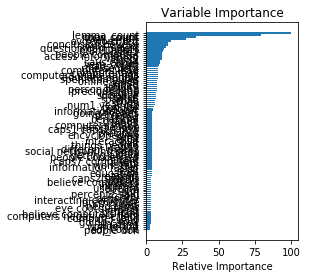

In [27]:
# Training a Gradient Boosting Regression model using all the features (BOW + other features)

params = {'n_estimators':[100, 1000], 'max_depth':[2], 'min_samples_split': [2],
          'learning_rate':[3, 1, 0.1, 0.3], 'loss': ['ls']}

gbr = ensemble.GradientBoostingRegressor()

grid = GridSearchCV(gbr, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

# Plot feature importance - to find the main factors affecting the final grade
feature_importance = grid.best_estimator_.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_names = list(features_set1.iloc[:, 3:].columns.values)
feature_names = np.asarray(feature_names + feature_names_cv)
sorted_idx = np.argsort(feature_importance)
# get top 100
sorted_idx = sorted_idx[9910:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [28]:
# splitting data (only 10 numerical/POS/orthographic features) into train data and test data (70/30)
    
X = features_set1.iloc[:, 3:].as_matrix()

y = features_set1['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [29]:
# Training a Linear Regression model using only 10 numerical/POS/orthographic features

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

Coefficients: 
 [ 2.92476287e-04  3.85323114e-03  4.44694862e-03  5.74300424e-01
  1.73859431e-02 -8.15450351e-03  1.96319345e-04 -9.19966941e-04
 -5.24254961e-03 -6.64586739e-03]
Mean squared error: 0.66
Variance score: 0.71
Cohen's kappa score: 0.35


In [30]:
# Training a Ridge Regression model (l2 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])

ridge_regressor = Ridge()

grid = GridSearchCV(estimator = ridge_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.7157859151935304
3.0
Mean squared error: 0.66
Variance score: 0.71
Cohen's kappa score: 0.35


In [31]:
# Training a Lasso Regression model (l1 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0.3, 0.1, 0.3])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.7161201657656007
0.1
Mean squared error: 0.67
Variance score: 0.71
Cohen's kappa score: 0.35


0.7524729987134586
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
MSE: 0.6014
Variance score: 0.73

Cohen's kappa score: 0.39


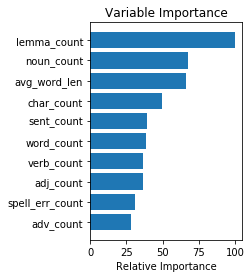

In [32]:
# Training a Gradient Boosting Regression model using only 10 numerical/POS/orthographic features

params = {'n_estimators':[50, 100, 500, 1000], 'max_depth':[2], 'min_samples_split': [2],
          'learning_rate':[1, 0.1, 0.3, 0.01], 'loss': ['ls']}

gbr = ensemble.GradientBoostingRegressor()

grid = GridSearchCV(gbr, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))
print()

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

# Plot feature importance - to find the main factors affecting the final grade
feature_importance = grid.best_estimator_.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_names = list(features_set1.iloc[:, 3:].columns.values)
feature_names = np.asarray(feature_names)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [30]:
# Training a Support Vector Regression model using only 10 numerical/POS/orthographic features

svr = SVR()

parameters = {'kernel':['linear', 'rbf'], 'C':[1, 100], 'gamma':[0.1, 0.001]}

grid = GridSearchCV(svr, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.5985696080037056
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Variance score: 0.65
Cohen's kappa score: 0.29


In [35]:
# Observations:
    
# 1. Using only BOW features:
#     Lasso Regression performs better than linear regression.

# 2. Using all features:
#     Lasso Regression performs much better than Linear Regression and Ridge Regression.
#     Gradient Boosting Regression performs better i.e. has a higher variance score and kappa score than all of the above.

# 3. Using only numerical/POS/orthographic features:
#     Support Vector Regression performs the worst among all other models.
#     Linear, Ridge and Lasso Regression have a similar performance.
#     Gradient Boosting Regression has the highest variance and kappa scores.

# Hence, we can observe that models trained with all the features (BOW + numerical/POS/orthographic features) and 
# models trained only with 10 numerical/POS/orthographic features produce similar scores.

# More features such as tf-idf scores, punctuation counts, essay sentiment, essay prompt etc can be added to improve 
# accuracy of prediction.